# Unlearning on Vision Transformers

## TODO: Use GPU, train tiny ViT on CIFAR-10 and test various unlearning methods such as SSD (on full first, then try subsets, such as combos of Q,K,V,O, or MLP, etc.

# ––––––––––

In [1]:
import copy
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
path = "./"

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/unlearning"

In [6]:
sys.path.append(path)

In [7]:
from vit_constants import *
from utils import set_seed
from cifar_10_utils import (
    train_data,
    val_data,
    train_loader,
    val_loader,
    invTrans,
    class_labels,
)
from models import get_vit_and_optimizer, get_attack_model_and_optimizer

set_seed()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
MODEL_NAME = f"ViT_CIFAR_10_ORIGINAL"
print("Model Name:", MODEL_NAME)

Model Name: ViT_CIFAR_10_ORIGINAL


# Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


Text(0.5, 1.0, 'horse')

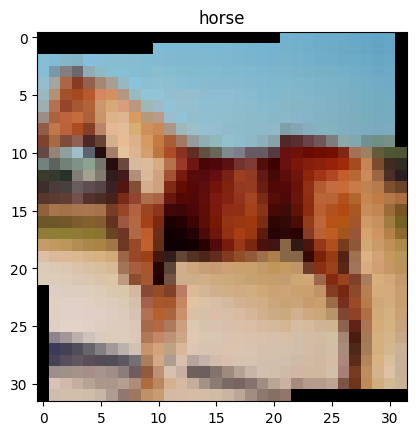

In [9]:
# (BATCH_SIZE, 3, 32, 32)

batch = next(iter(train_loader))
print(batch[0].shape)
test_idx = 43
plt.imshow(invTrans(batch[0][test_idx]).permute(1, 2, 0))
plt.title(f"{class_labels[batch[1][test_idx]]}")

# Standard Training

In [10]:
def train(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    model.to(device)
    train_losses, val_losses = [], []
    val_accuracies = []

    for epoch in range(EPOCHS):

        print(f"Epoch {epoch+1}/{EPOCHS}")

        for step, (img, label) in enumerate(train_loader):

            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            train_losses.append(loss.item())  # every step
            loss.backward()

            # Monitoring overall gradient norm
            grads = [
                param.grad.detach().flatten()
                for param in model.parameters()
                if param.grad is not None
            ]
            norm = torch.cat(grads).norm()

            optimizer.step()

            if step % PRINT_ITERS == 0 and step != 0:
                val_loss, val_acc = eval(model, val_loader, criterion, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                print(
                    f"Step: {step}/{len(train_loader)}, Running Average Loss: {np.mean(train_losses):.3f} |",
                    f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Grad Norm: {norm:.2f}",
                )
                model.train()

        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{epoch+1}_SEED_{SEED}.pt",
        )

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "w"
        ) as f:
            json.dump(train_losses, f)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "w"
        ) as f2:
            json.dump(val_losses, f2)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "w"
        ) as f3:
            json.dump(val_accuracies, f3)

    return train_losses, val_losses, val_accuracies

In [11]:
def eval(model, val_loader, criterion, device):
    val_losses = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for i, (img, label) in enumerate(val_loader):

            img, label = img.to(device), label.to(device)
            out = model(img)

            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())

            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / ((len(val_loader) - 1) * BATCH_SIZE + label.size(0))

    return val_loss, val_acc

In [15]:
model, optimizer = get_vit_and_optimizer(
    seed=42,
    n_embd=128,
    n_head=4,
    n_ff=128 * 4,
    n_layer=4,
    n_class=10,  # CIFAR-10
    img_size=32,  # CIFAR-10
    patch_size=4,
    device=device,
    norm_first=True,
    n_kv_head=2,
    dropout=0.1,
)

model.to(device)
# summary(model)

criterion = nn.CrossEntropyLoss()

In [14]:
## Driver code
train_losses, val_losses, val_accuracies = train(
    model, train_loader, val_loader, optimizer, criterion, device
)

Epoch 1/10
Step: 50/782, Running Average Loss: 2.205 | Val Loss: 2.037 | Val Acc: 0.235 | Grad Norm: 1.96
Step: 100/782, Running Average Loss: 2.110 | Val Loss: 1.949 | Val Acc: 0.287 | Grad Norm: 1.75
Step: 150/782, Running Average Loss: 2.069 | Val Loss: 1.963 | Val Acc: 0.270 | Grad Norm: 2.12
Step: 200/782, Running Average Loss: 2.037 | Val Loss: 1.837 | Val Acc: 0.323 | Grad Norm: 2.43
Step: 250/782, Running Average Loss: 2.008 | Val Loss: 1.798 | Val Acc: 0.341 | Grad Norm: 1.92
Step: 300/782, Running Average Loss: 1.980 | Val Loss: 1.751 | Val Acc: 0.362 | Grad Norm: 2.78


KeyboardInterrupt: 

# Sanity check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

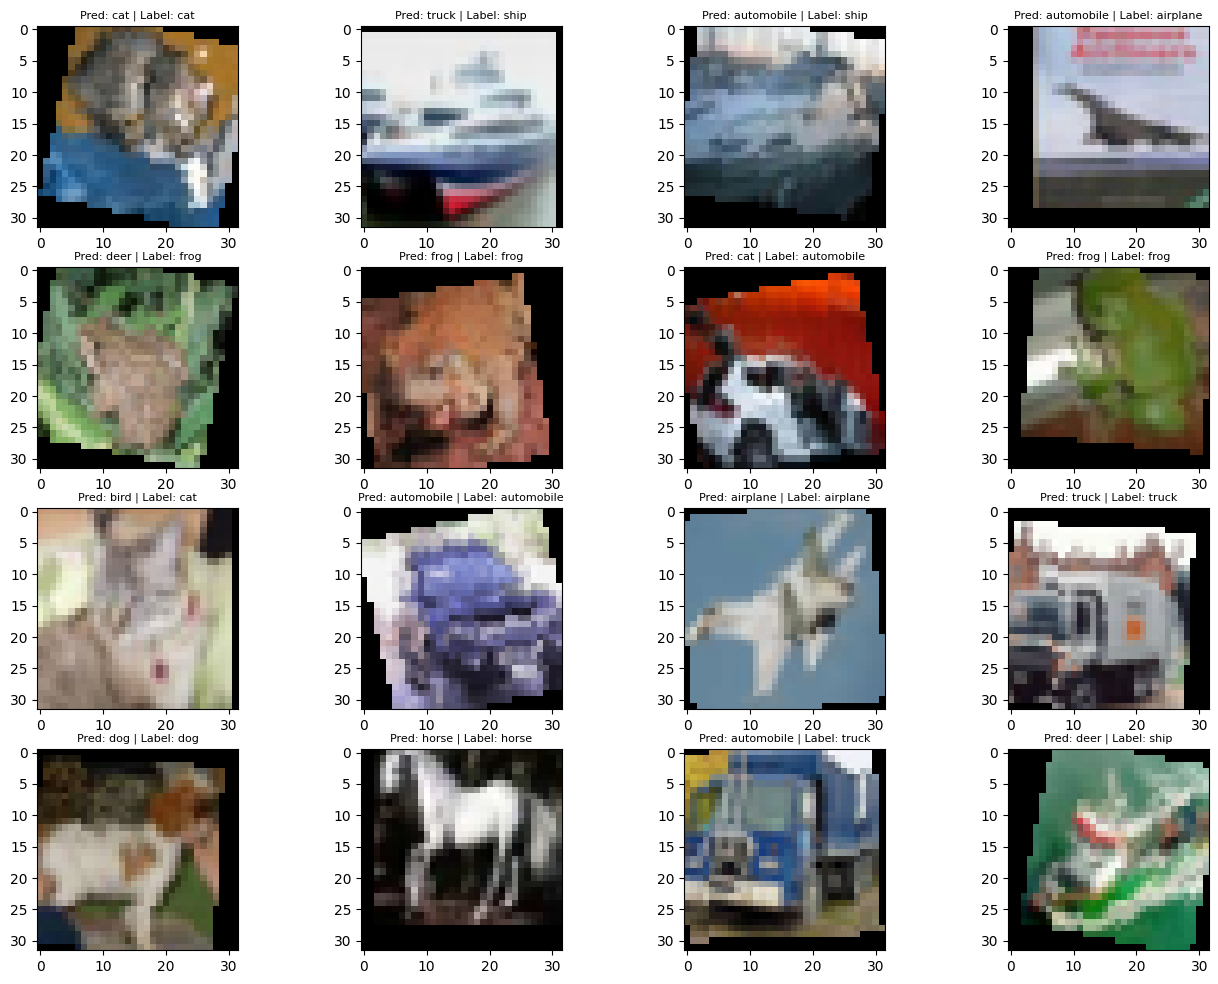

In [16]:
model.eval()
with torch.no_grad():
    img, label = next(iter(val_loader))
    # choose one batch from val and one batch from forget
    img, label = img.to(device), label.to(device)
    out = model(img)
    pred = out.argmax(dim=-1)

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
for i, ax in enumerate(axes.ravel()):
    ax.set_title(
        f"Pred: {class_labels[pred[i]]} | Label: {class_labels[label[i]]}", fontsize=8
    )
    ax.imshow(invTrans(img[i]).cpu().permute(1, 2, 0))
plt.show()